# Imports and Defaults

In [1]:
import os

import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
posterior = "funnel10" # modify as needed
num_params = 10 # modify as needed

sns.set_style("darkgrid")
fig_path = os.path.join("../figures", posterior)

# Load Dataframe

In [3]:
samples_path = os.path.join("../data/processed/", posterior, "samples.parquet")
samples = pl.read_parquet(samples_path)
samples

sampler,chain,sampler_type,init_stepsize,reduction_factor,steps,dampening,num_proposals,probabilistic,grad_evals,proposal_nans,ghost_nans,se1_p0,se1_p1,se1_p2,se1_p3,se1_p4,se1_p5,se1_p6,se1_p7,se1_p8,se1_p9,se2_p0,se2_p1,se2_p2,se2_p3,se2_p4,se2_p5,se2_p6,se2_p7,se2_p8,se2_p9,std_p0,std_p1,std_p2,std_p3,std_p4,std_p5,std_p6,std_p7,std_p8,std_p9
cat,u8,cat,f32,u8,str,f32,u8,bool,u32,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""drghmc_40""",0,"""drghmc""",8.0,2,"""const_traj_len…",0.01,3,false,454492,0,643,0.341316,0.010356,0.000107,0.001092,0.000035,0.007824,0.003022,0.006096,0.00001,0.005166,24.307705,30.232793,1.781144,0.380125,1.682216,3.629296,28.955539,7.363006,7.814392,32.605172,1.931183,2.67131,1.72594,1.504692,1.718789,1.883992,2.650171,2.088936,2.10806,2.711992
"""drghmc_40""",1,"""drghmc""",8.0,2,"""const_traj_len…",0.01,3,false,331263,0,50,0.622306,0.027289,0.029655,0.032308,0.000287,0.051834,0.160561,0.137214,0.021311,0.00806,9.235001,369.683864,139.253054,236.254922,62.001762,456.065045,207.013467,504.956195,316.154243,207.288342,2.308775,4.565801,3.662712,4.12149,3.087249,4.791198,3.983988,4.898053,4.405434,4.004888
"""drghmc_40""",2,"""drghmc""",8.0,2,"""const_traj_len…",0.01,3,false,289875,0,16,1.338758,0.003009,0.107917,3.360914,0.00077,4.677226,3.729115,1.12474,2.699661,0.112387,3.36948,2642.48008,15960.909423,28239.167669,4451.363353,20548.515989,5962.731107,10106.909771,32403.211074,3814.277964,3.079934,7.28352,11.308107,12.897132,8.268919,11.846081,8.668254,10.053199,13.377542,7.955921
"""drghmc_40""",3,"""drghmc""",8.0,2,"""const_traj_len…",0.01,3,false,102062,0,0,0.046444,0.238781,0.013958,0.105378,0.187177,0.209146,0.028667,0.107222,0.134107,0.027264,0.000003,1189.78916,360.508302,1860.606644,2075.003036,382.345298,1178.473877,2701.111768,1584.558851,510.42112,2.991244,5.991645,4.540636,6.684125,6.857261,4.582403,5.995502,7.315762,6.42815,4.920913
"""drghmc_40""",4,"""drghmc""",8.0,2,"""const_traj_len…",0.01,3,false,97383,0,0,0.031422,0.094914,0.015848,0.071786,0.00327,0.024486,0.000481,0.00127,0.202651,0.025005,5.381257,306.130461,135.901067,176.621615,121.881422,66.602421,70.599941,203.231276,802.867525,144.623904,2.578198,4.364674,3.645041,3.855811,3.562857,3.128659,3.169755,3.988837,5.457198,3.694739
"""drghmc_40""",5,"""drghmc""",8.0,2,"""const_traj_len…",0.01,3,false,332474,0,18,1.3441,0.638661,0.174967,0.003334,0.000271,0.012907,1.719651,0.353587,0.623709,1.108088,5.427526,2431.832708,431.101387,691.293828,1134.673792,509.77809,2000.787036,2230.479638,2158.085045,4368.899778,2.305497,7.094067,4.715169,5.285616,5.944907,4.921123,6.682335,6.966287,6.890603,8.163178
"""drghmc_40""",6,"""drghmc""",8.0,2,"""const_traj_len…",0.01,3,false,85992,0,0,0.895727,0.071255,0.000143,0.00796,0.007458,0.007657,0.019196,0.000647,0.003144,0.004714,0.000809,59.147835,10.606038,6.765794,6.502763,6.441047,10.708778,12.218015,8.065612,2.681044,2.852414,3.043967,2.213809,2.059614,2.049343,2.045103,2.213363,2.269566,2.117875,1.811806
"""drghmc_40""",7,"""drghmc""",8.0,2,"""const_traj_len…",0.01,3,false,280697,0,23,0.003701,0.066834,0.040664,1.234303,0.014528,0.007066,1.188844,0.261038,0.128261,0.868991,1.753934,694.973185,255.163739,3063.123069,462.494497,226.621752,8787.993762,2031.449712,1524.341819,3908.210632,2.769221,5.286209,4.192585,7.467129,4.811288,4.086452,9.70582,6.816563,6.368929,7.956019
"""drghmc_40""",8,"""drghmc""",8.0,2,"""const_traj_len…",0.01,3,false,66892,0,0,1.934488,0.030875,0.556327,0.000004,0.003764,0.002628,0.262285,0.133052,0.277145,0.042502,0.572291,660.576939,1161.936864,1995.420315,366.358135,364.097165,1354.828851,2853.615904,786.475493,1211.673019,2.509293,5.226609,5.930812,6.805793,4.560046,4.553166,6.179979,7.412252,5.423583,6.034634


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Gradient evaluations Per Sampler Type')

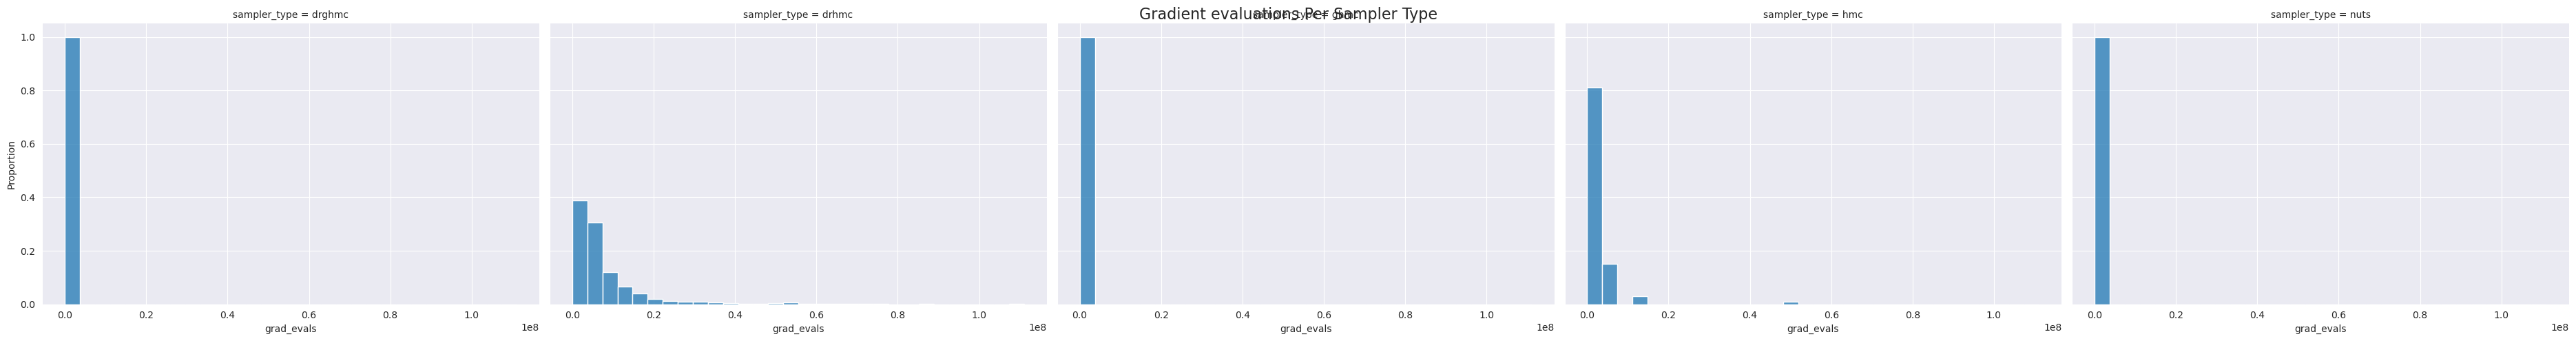

In [4]:
facet = sns.displot(
    kind="hist",
    data=samples,
    x="grad_evals",
    bins=30,
    stat="proportion",
    col="sampler_type",
    common_norm=False,
    common_bins=True,
    aspect=1.5,
)
facet.fig.suptitle(f"Gradient evaluations Per Sampler Type", fontsize=16)

# Squared Error

Text(0.5, 0.98, 'Efficiency of Parameters')

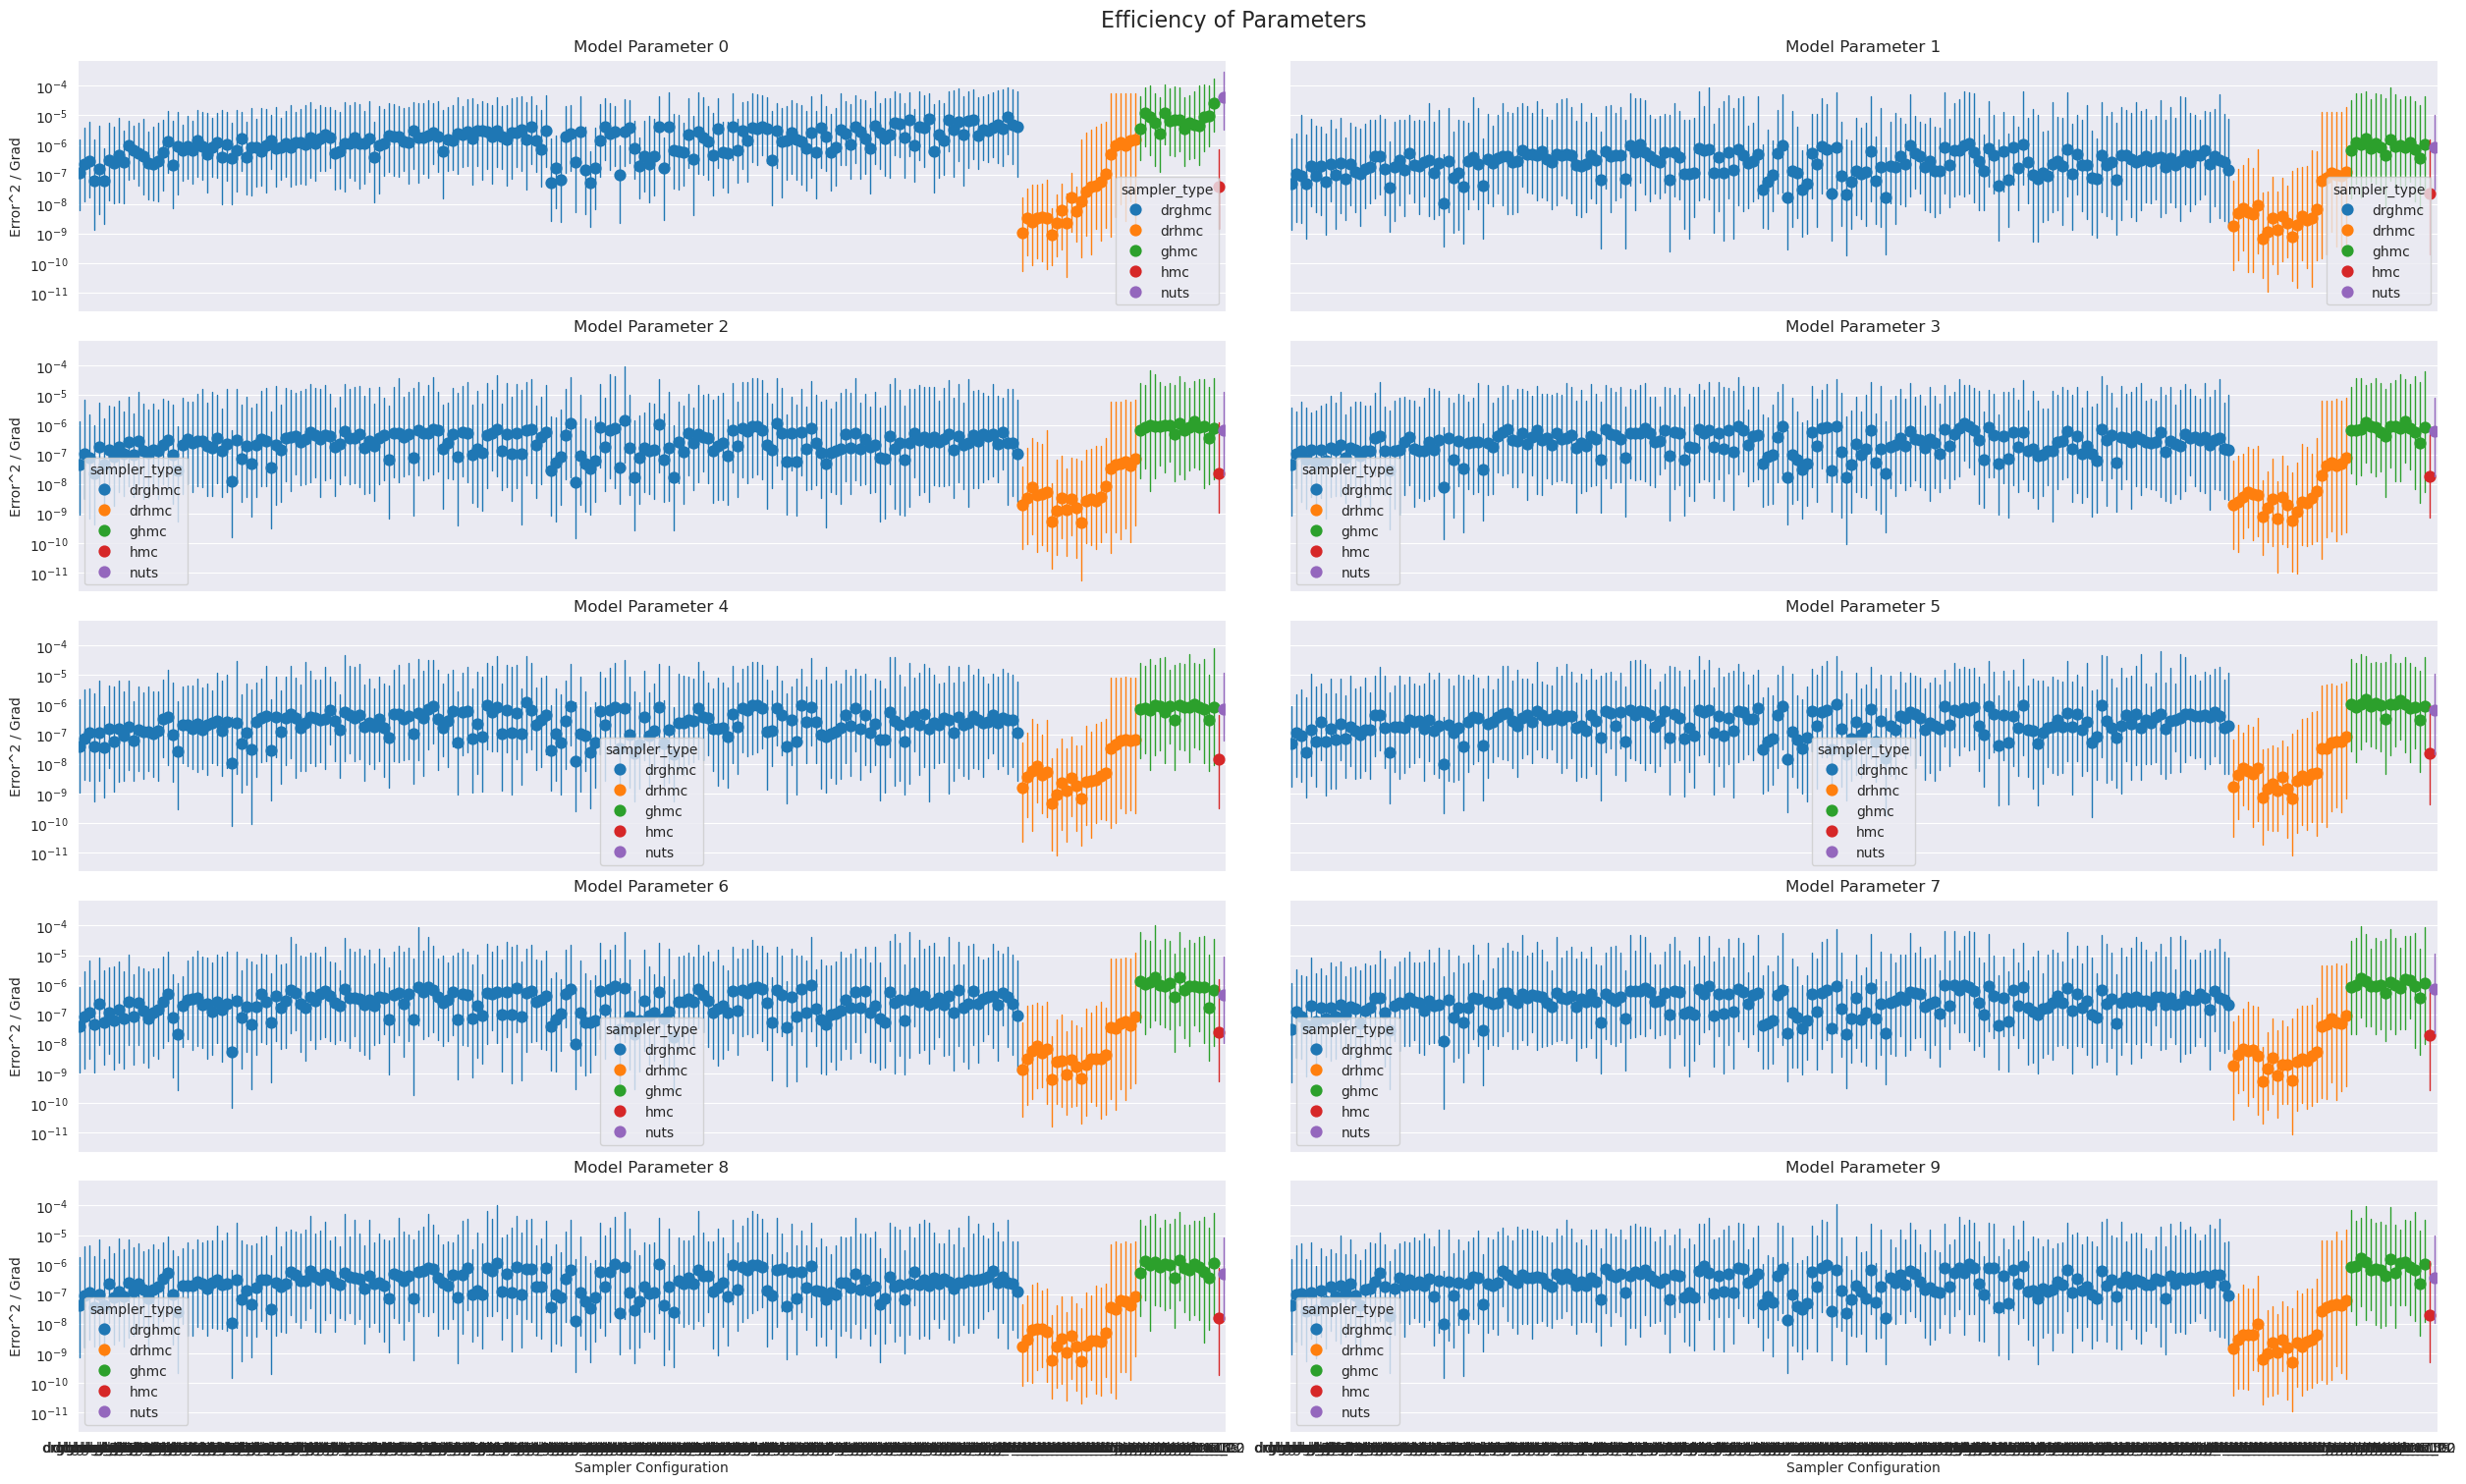

In [22]:
id_vars = ["sampler", "chain", "sampler_type", "init_stepsize", "reduction_factor", "steps", "dampening", "num_proposals", "probabilistic", "grad_evals", "proposal_nans", "ghost_nans"]
value_vars = [f"se1_p{i}" for i in range(num_params)]

fig, axes = plt.subplots(nrows=num_params // 2, ncols=2, figsize=(25, 15), sharex=True, sharey=True, gridspec_kw={"wspace": 0.005}, layout="constrained")

for idx, ax in enumerate(axes.flatten()):
    param = f"se1_p{idx}"
    df = samples.select(id_vars + [pl.col(param) / pl.col("grad_evals")])
    
    if idx == 0:
        order_df = (
            df.lazy()
            .group_by(["sampler_type", "sampler"])
            .mean()
            .sort(by=["sampler_type", param])
            .select("sampler")
        ).collect()
        
        order = order_df["sampler"].to_list()

    sns.pointplot(
        data=df,
        x="sampler",
        y=param,
        hue="sampler_type",
        estimator="mean",
        errorbar=("pi", 80),
        log_scale=True,
        order=order,
        linestyle="none",
        err_kws={"linewidth": 1},
        seed=1234,
        ax=ax,
    )

    ax.set_title(f"Model Parameter {idx}")
    ax.set_ylabel("Error^2 / Grad")
    ax.set_xlabel("Sampler Configuration")

fig.suptitle(f"Efficiency of Parameters", fontsize=16)
# fig.legend()

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


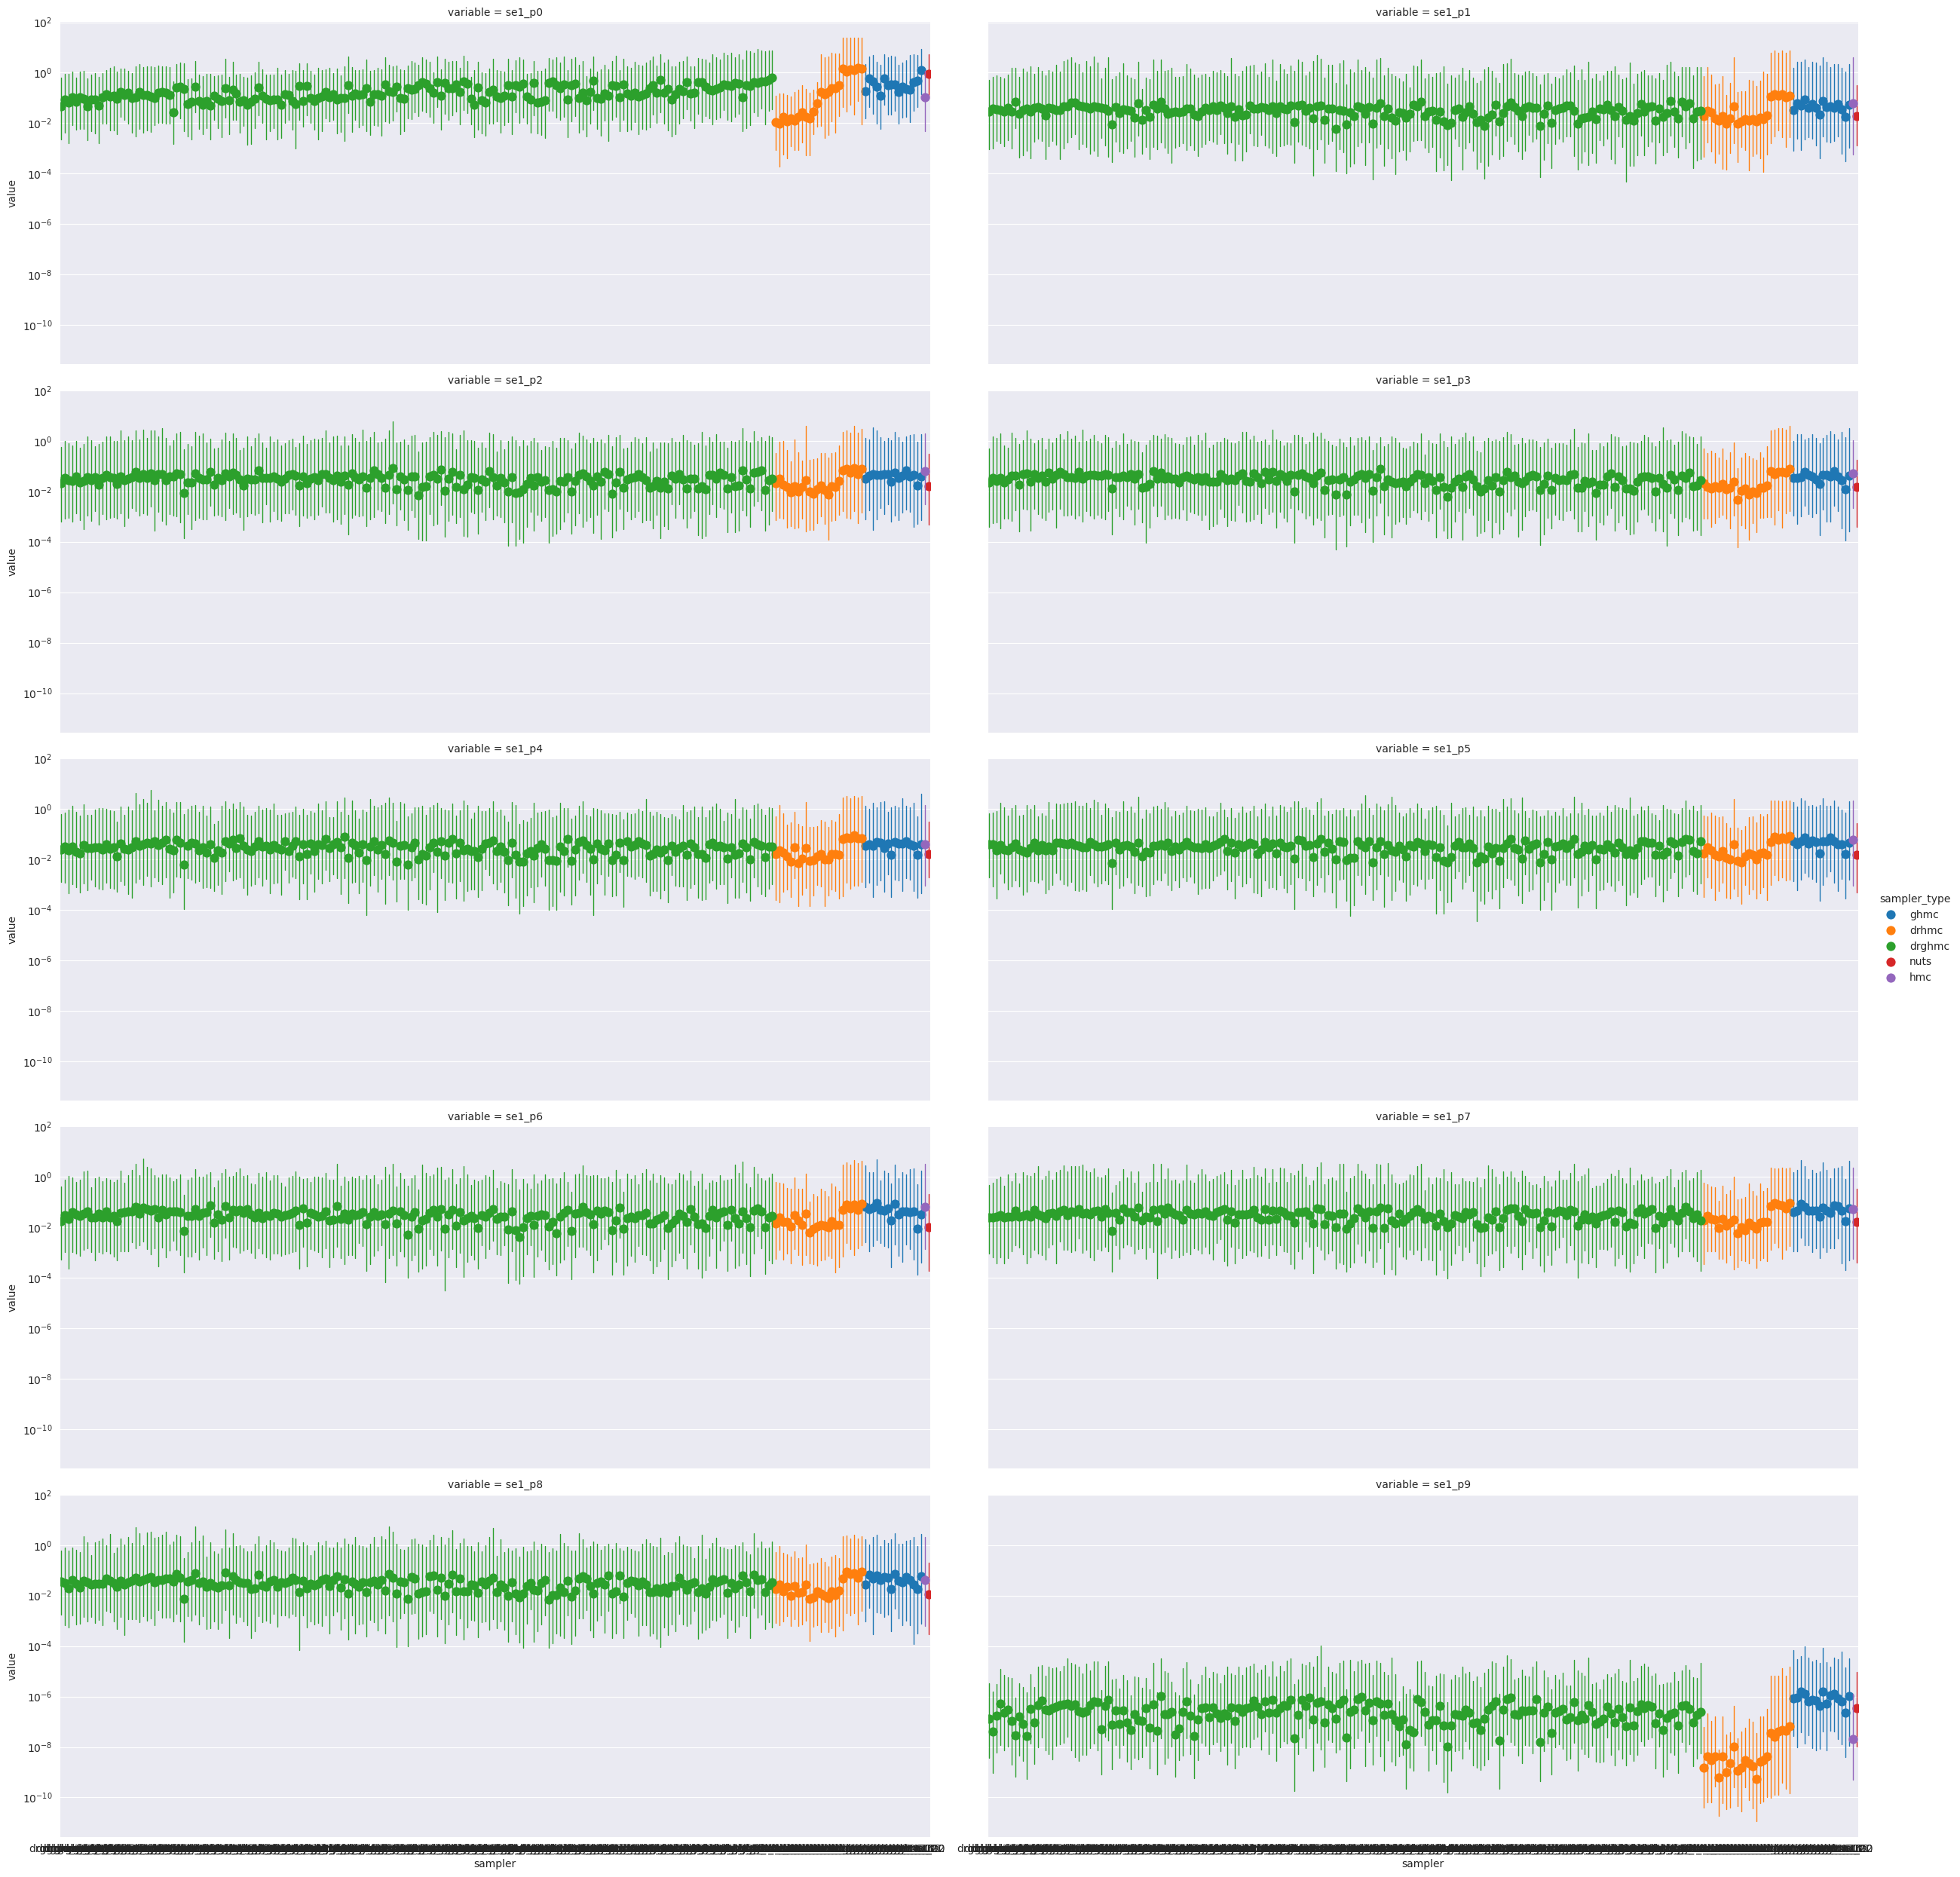

In [9]:
value_vars = [f"se1_p{i}" for i in range(num_params)]
id_vars = [col for col in samples.columns if col not in value_vars]

tmp = samples
for col_name in value_vars:
    tmp = samples.lazy().with_columns(
        (pl.col(col_name) / pl.col("grad_evals"))
    ).collect()

samples_melted = tmp.melt(id_vars=id_vars, value_vars=value_vars)

# Filter the DataFrame where the "variable" column is "se1_p0"
filtered_df = samples_melted.filter(samples_melted["variable"] == "se1_p0")
grouped_df = filtered_df.group_by(["sampler", "sampler_type"]).agg(
    pl.col("value").mean().alias("mean_value")
)
sorted_df = grouped_df.sort(["sampler_type", "mean_value"])
sorted_samplers = sorted_df["sampler"].to_list()

fig = sns.catplot(
    kind="point",
    data=samples_melted,
    x="sampler",
    y="value",
    hue="sampler_type",
    estimator="mean",
    errorbar=("pi", 80),
    seed=1234,
    col="variable",
    col_wrap=2,
    sharey=True,
    sharex=True,
    height=5,
    aspect=2.5,
    log_scale=True,
    col_order=[f"se1_p{i}" for i in range(num_params)],
    linestyle="none",
    hue_order=["ghmc", "drhmc", "drghmc", "nuts", "hmc"],
    err_kws={"linewidth": 1},
    order=sorted_samplers,
)

# Hyper-Param Analysis With Seaborn

In [12]:
hp = "dampening"

id_vars = ["sampler", "chain", "sampler_type", "init_stepsize", "reduction_factor", "steps", "dampening", "num_proposals", "probabilistic", "grad_evals", "proposal_nans", "ghost_nans"]
sampler_vars = ["sampler", "chain", "sampler_type", "init_stepsize", "reduction_factor", "steps", "dampening", "num_proposals", "probabilistic",]
value_vars = [f"se1_p{i}" for i in range(num_params)]

unique_samplers_df = (samples
                        .group_by("sampler_type")
                        .count()
                        .sort("count", descending=True)
)
unique_samplers_count = unique_samplers_df["count"].to_list()
unique_samplers = unique_samplers_df["sampler_type"].to_list()

df = (samples.lazy()
        .select(id_vars + [pl.col(param) / pl.col("grad_evals") for param in value_vars]) # compute error^2 / grad
        .with_columns( # add index column to pivot on hyperparameter of interest
            pl.concat_str(
                [pl.col(col_name).cast(pl.Utf8) for col_name in sampler_vars if col_name != hp], 
                separator="_"
            )
            .alias("index")
            .cast(pl.Categorical)
        )
        .melt(id_vars=id_vars + ["index"], value_vars=value_vars) # melt for easy plotting
).collect()

# df = df.filter(df["variable"] == "se1_p0")  # TODO: remove

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/categorical.py:374: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


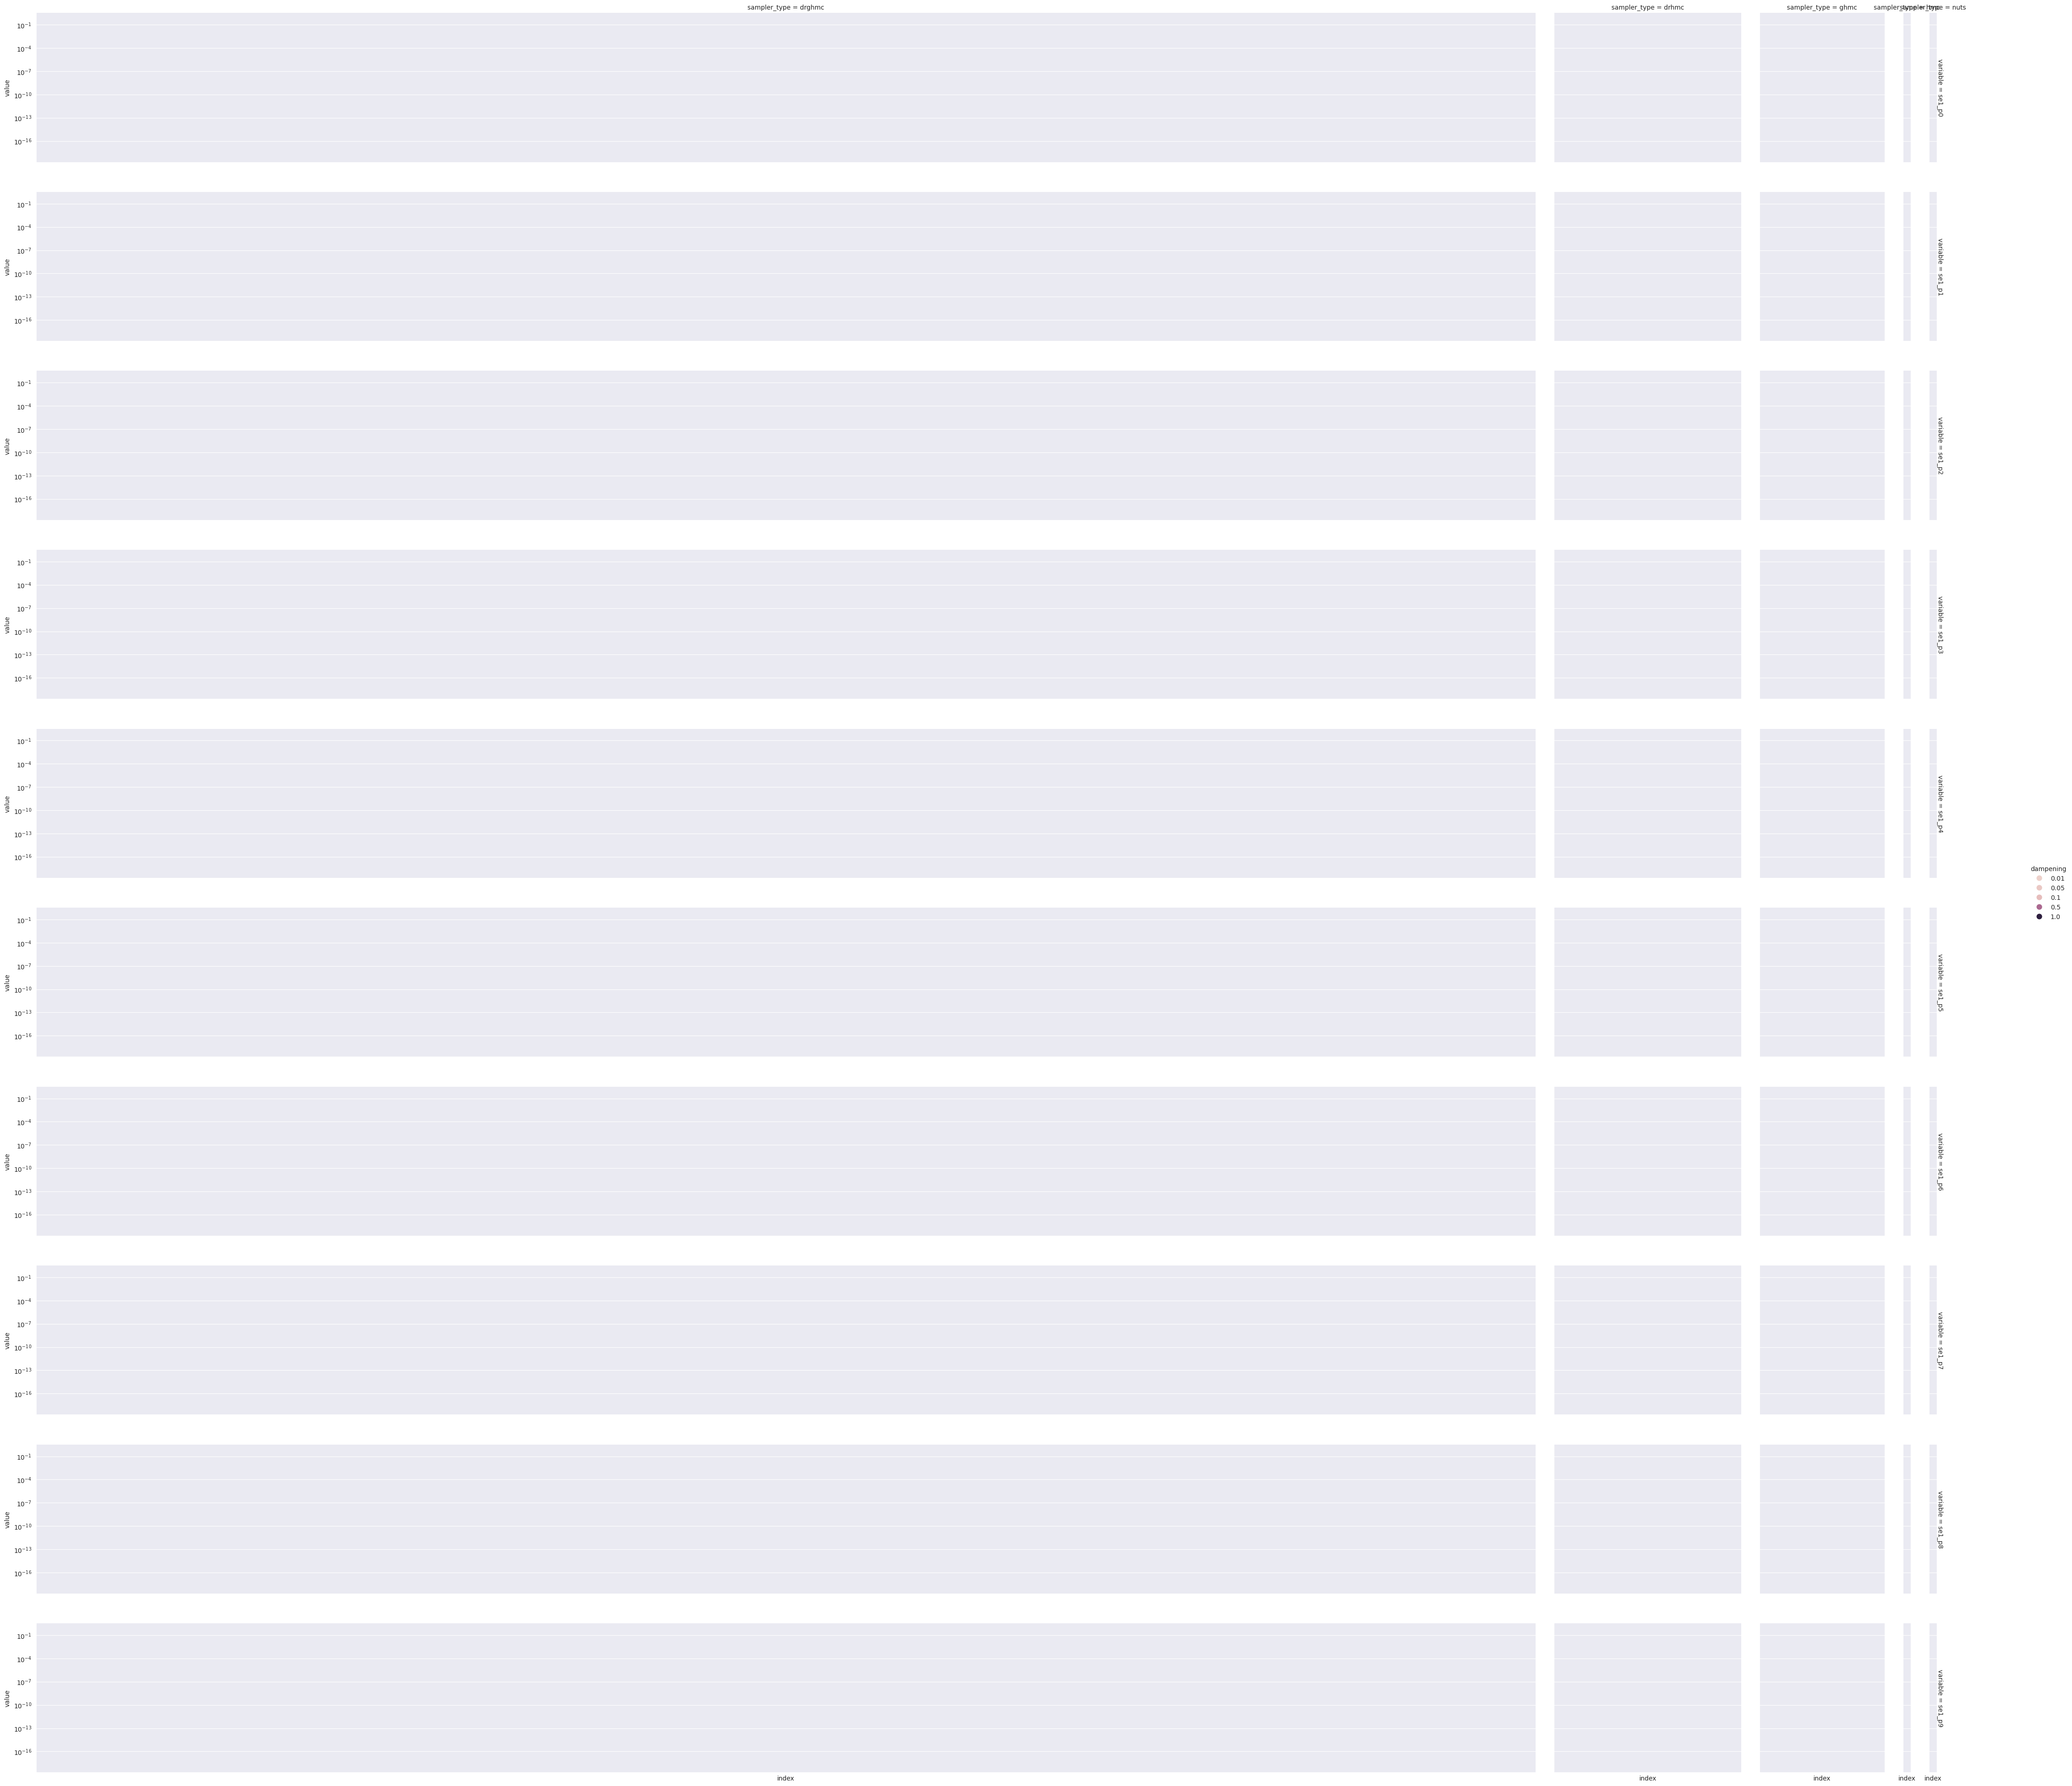

In [13]:
fig = sns.catplot(
    kind="point",
    data=df,
    x="index",
    y="value",
    hue=hp,
    estimator="mean",
    # errorbar=("pi", 80),
    row="variable",
    col="sampler_type",
    # height=10,
    aspect=2,
    log_scale=True,
    # order=sorted_samplers,
    col_order=unique_samplers,
    # row_order=[f"se1_p{i}" for i in range(num_params)],
    seed=1234,
    linestyle="none",
    margin_titles=True,
    err_kws=dict(linewidth=1),
    facet_kws=dict(
        gridspec_kws=dict(width_ratios=unique_samplers_count, wspace=0.05),
        subplot_kws=dict(xticks=[], label=None),
    ),
)

In [5]:
hp = "dampening"

id_vars = ["sampler", "chain", "sampler_type", "init_stepsize", "reduction_factor", "steps", "dampening", "num_proposals", "probabilistic", "grad_evals", "proposal_nans", "ghost_nans"]
sampler_vars = ["sampler", "chain", "sampler_type", "init_stepsize", "reduction_factor", "steps", "dampening", "num_proposals", "probabilistic",]
value_vars = [f"se1_p{i}" for i in range(num_params)]

unique_samplers_df = (samples
                        .group_by("sampler_type")
                        .count()
                        .sort("count", descending=True)
)
unique_samplers_count = unique_samplers_df["count"].to_list()
unique_samplers = unique_samplers_df["sampler_type"].to_list()

fig, axes = plt.subplots(nrows=num_params, ncols=len(unique_samplers_count), figsize=(25, 15), sharex=True, sharey=True, gridspec_kw={"wspace": 0.005, "hspace": 0.0001}, layout="constrained", width_ratios=unique_samplers_count)

for row, row_axes in enumerate(axes):
    for col, ax in enumerate(row_axes):
        
        param = f"se1_p{row}"
        sampler_type = unique_samplers[col]
        df = (samples.lazy()
                .select(id_vars + [pl.col(param) / pl.col("grad_evals")])
                .filter(pl.col("sampler_type") == sampler_type)
                .with_columns(
                    pl.concat_str([pl.col(col_name).cast(pl.Utf8) for col_name in sampler_vars if col_name != hp], separator="_").alias("index")
                )
        ).collect()

        sns.pointplot(
        data=df,
            x="index",
            y=param,
            hue=hp,
            estimator="mean",
            # errorbar=("pi", 80),
            log_scale=True,
            # order=order,
            linestyle="none",
            err_kws={"linewidth": 1},
            seed=1234,
            ax=ax,
            legend=False,
        )

        # ax.set_title(f"Model Parameter {idx}")
        ax.set_ylabel("Error^2 / Grad")
        ax.set_xlabel("Sampler Configuration")
        break
    break

Error in callback <function _draw_all_if_interactive at 0x1551f7c80680> (for post_execute):


KeyboardInterrupt: 